# Evaluating the Robustness of Off-Policy Evaluation

## Setup

In [ ]:
!pip install -q obp

In [ ]:
!pip install matplotlib==3.1.1

In [ ]:
!pip install -U pandas

## Imports

In [1]:
from abc import ABCMeta, abstractmethod
from typing import Union
from scipy.stats import loguniform

from inspect import isclass
from pathlib import Path
from typing import Optional, List, Tuple, Union, Dict
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection._search import BaseSearchCV
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    mean_squared_error as calc_mse,
    mean_absolute_error as calc_mae,
)
from obp.ope import (
    RegressionModel,
    OffPolicyEvaluation,
    BaseOffPolicyEstimator,
)
from obp.types import BanditFeedback

import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.model_selection import RandomizedSearchCV

import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner
from obp.ope import (
    DirectMethod,
    DoublyRobust,
    DoublyRobustWithShrinkage,
    InverseProbabilityWeighting,
)
from obp.dataset import MultiClassToBanditReduction

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Utils

In [2]:
def _choose_uniform(
    s: int,
    lower: Union[int, float],
    upper: Union[int, float],
    type_: type,
) -> Union[int, float]:
    np.random.seed(seed=s)
    assert lower <= upper, "`upper` must be larger than or equal to `lower`"
    assert type_ in [int, float], f"`type_` must be int or float but {type_} is given"
    if lower == upper:
        return lower
    if type_ == int:
        return np.random.randint(lower, upper, dtype=type_)
    else:  # type_ == float:
        return np.random.uniform(lower, upper)


def _choose_log_uniform(
    s: int,
    lower: Union[int, float],
    upper: Union[int, float],
    type_: type,
) -> Union[int, float]:
    assert (
        lower > 0
    ), f"`lower` must be greater than 0 when drawing from log uniform distribution but {lower} is given"
    assert lower <= upper, "`upper` must be larger than or equal to `lower`"
    assert type_ in [int, float], f"`type_` must be int or float but {type_} is given"
    if lower == upper:
        return lower
    if type_ == int:
        return int(loguniform.rvs(lower, upper, random_state=s))
    else:  # type_ == float:
        return loguniform.rvs(lower, upper, random_state=s)

## OPE Evaluators

In [3]:
class BaseOPEEvaluator(metaclass=ABCMeta):
    @abstractmethod
    def estimate_policy_value(self) -> None:
        """Estimate policy values."""
        raise NotImplementedError

    @abstractmethod
    def calculate_squared_error(self) -> None:
        """Calculate squared errors."""
        raise NotImplementedError

    @abstractmethod
    def visualize_cdf(self) -> None:
        """Create graph of cumulative distribution function of an estimator."""
        raise NotImplementedError

    @abstractmethod
    def visualize_cdf_aggregate(self) -> None:
        """Create graph of cumulative distribution function of all estimators."""
        raise NotImplementedError

    @abstractmethod
    def save_policy_value(self) -> None:
        """Save estimate policy values to csv file."""
        raise NotImplementedError

    @abstractmethod
    def save_squared_error(self) -> None:
        """Save squared errors to csv file."""
        raise NotImplementedError

    @abstractmethod
    def calculate_au_cdf_score(self) -> None:
        """Calculate AU-CDF score."""
        raise NotImplementedError

    @abstractmethod
    def calculate_cvar_score(self) -> None:
        """Calculate CVaR score."""
        raise NotImplementedError

In [4]:
COLORS = [
    "lightcoral",
    "plum",
    "lightgreen",
    "lightskyblue",
    "lightsalmon",
    "orange",
    "forestgreen",
    "royalblue",
    "gold",
    "blueviolet",
    "fuchsia",
    "lightpink",
    "firebrick",
    "peru",
    "darkkhaki",
    "darkolivegreen",
    "navy",
    "deeppink",
    "black",
    "silver",
]

LINESTYLES = [
    "solid",
    (0, (1, 0.6)),
    (0, (1, 1.2)),
    (0, (1, 1.8)),
    (0, (1, 2.4)),
    (0, (1, 3)),
]


@dataclass
class InterpretableOPEEvaluator(BaseOPEEvaluator):
    """Class to carry out Interpretable OPE Evaluation.
    Parameters
    ----------
    random_states: np.ndarray
        list of integers representing random states
        length of random_states corresponds to the number of runs
    bandit_feedbacks: List[BanditFeedback]
        list of bandit feedbacks
    evaluation_policies: List[Tuple[float, np.ndarray]]
        list of tuples representing evaluation policies
        first entry in tuple represents the ground truth policy value
        second entry in tuple represents action distribution of evaluation policy
    ope_estimators: List[BaseOffPolicyEstimator]
        list of ope estimators from obp.ope
    ope_estimator_hyperparams: dict
        dictionary storing hyperparameters for ope estimators
        must be in the following format
            ope_estimator_hyperparams = dict(
                [OffPolicyEstimator].estimator_name = dict(
                    [parameter_name] = dict(
                        "lower":
                        "upper":
                        "log":
                        "type":
                    )
                ),
            )
    regression_models: Optional[List[Union[BaseEstimator, BaseSearchCV]]]
        list of regression models to be used in off policy evaluation
        each element must either be of type BaseEstimator or BaseSearchCV
    regression_model_hyperparams: dict
        dictionary storing hyperparameters for regression models
        must be in the following format
            regression_model_hyperparams = dict(
                [model_name] = dict(
                    [parameter_name] = dict(
                        "lower":
                        "upper":
                        "log":
                        "type":
                    )
                ),
            )
    pscore_estimators: Optional[List[Union[BaseEstimator, BaseSearchCV]]]
        list of classification models to be used in estimating propensity scores of behavior policy
        each element must either be of type BaseEstimator or BaseSearchCV
    pscore_estimator_hyperparams: dict
        dictionary storing hyperparameters for pscore estimators
        must be in the following format
            pscore_estimator_hyperparams = dict(
                [model_name] = dict(
                    [parameter_name] = dict(
                        "lower":
                        "upper":
                        "log":
                        "type":
                    )
                ),
            )
    """

    random_states: np.ndarray
    ope_estimators: List[BaseOffPolicyEstimator]
    bandit_feedbacks: List[BanditFeedback]
    evaluation_policies: List[Tuple[float, np.ndarray]]
    ope_estimator_hyperparams: Optional[dict] = None
    regression_models: Optional[List[Union[BaseEstimator, BaseSearchCV]]] = None
    regression_model_hyperparams: Optional[dict] = None
    pscore_estimators: Optional[List[Union[BaseEstimator, BaseSearchCV]]] = None
    pscore_estimator_hyperparams: Optional[dict] = None

    def __post_init__(self) -> None:
        self.estimator_names = [est.estimator_name for est in self.ope_estimators]
        self.policy_value = None
        for i in np.arange(len(self.bandit_feedbacks)):
            if self.bandit_feedbacks[i]["position"] is None:
                self.bandit_feedbacks[i]["position"] = np.zeros_like(
                    self.bandit_feedbacks[i]["action"],
                    dtype=int,
                )
        if self.reward_type == "binary":
            self.reg_model_metric_names = ["auc", "rel_ce"]
        else:
            self.reg_model_metric_names = ["rel_mse", "rel_mae"]

        if not self.ope_estimator_hyperparams:
            self.ope_estimator_hyperparams = {
                estimator_name: dict() for estimator_name in self.estimator_names
            }

        if not self.regression_model_hyperparams:
            self.regression_model_hyperparams = {
                regression_model: dict() for regression_model in self.regression_models
            }

        if self.pscore_estimators and not self.pscore_estimator_hyperparams:
            self.pscore_estimator_hyperparams = {
                pscore_estimator: dict() for pscore_estimator in self.pscore_estimators
            }

    @property
    def n_runs(self) -> int:
        """Number of iterations."""
        return self.random_states.shape[0]

    @property
    def n_rounds(self) -> np.ndarray:
        """Number of observations in each given bandit_feedback in self.bandit_feedbacks"""
        return np.asarray(
            [bandit_feedback["n_rounds"] for bandit_feedback in self.bandit_feedbacks]
        )

    @property
    def n_actions(self) -> np.ndarray:
        """Number of actions in each given bandit_feedback in self.bandit_feedbacks"""
        return np.asarray(
            [bandit_feedback["n_actions"] for bandit_feedback in self.bandit_feedbacks]
        )

    @property
    def reward_type(self) -> np.ndarray:
        """Whether the reward is binary or continuous"""
        if np.unique(self.bandit_feedbacks[0]["reward"]).shape[0] == 2:
            return "binary"
        else:
            return "continuous"

    @property
    def len_list(self) -> np.ndarray:
        """Number of positions in each given bandit_feedback in self.bandit_feedbacks"""
        return np.asarray(
            [
                int(bandit_feedback["position"].max() + 1)
                for bandit_feedback in self.bandit_feedbacks
            ]
        )

    def estimate_policy_value(
        self,
        n_folds_: Union[int, Optional[dict]] = 2,
        sample_size: Optional[int] = None,
    ) -> dict:
        """Estimates the policy values using selected ope estimators under a range of environments."""
        # initialize dictionaries to store results
        self.policy_value = {est: np.zeros(self.n_runs) for est in self.estimator_names}
        self.squared_error = {
            est: np.zeros(self.n_runs) for est in self.estimator_names
        }
        self.reg_model_metrics = {
            metric: np.zeros(self.n_runs) for metric in self.reg_model_metric_names
        }
        for i, s in enumerate(tqdm(self.random_states)):
            np.random.seed(seed=s)
            # randomly select bandit_feedback
            self.bandit_feedback = self._choose_bandit_feedback(s)

            if self.pscore_estimators is not None:
                # randomly choose pscore estimator
                pscore_estimator = np.random.choice(self.pscore_estimators)
                # randomly choose hyperparameters of pscore estimator
                if isinstance(pscore_estimator, BaseEstimator):
                    classifier = pscore_estimator
                    setattr(classifier, "random_state", s)
                elif isclass(pscore_estimator) and issubclass(
                    pscore_estimator, BaseEstimator
                ):
                    pscore_estimator_hyperparam = (
                        self._choose_pscore_estimator_hyperparam(s, pscore_estimator)
                    )
                    classifier = clone(pscore_estimator(**pscore_estimator_hyperparam))
                else:
                    raise ValueError(
                        f"pscore_estimator must be BaseEstimator or BaseSearchCV, but {type(pscore_estimator)} is given."
                    )
                # fit classifier
                classifier.fit(
                    self.bandit_feedback["context"], self.bandit_feedback["action"]
                )
                estimated_pscore = classifier.predict_proba(
                    self.bandit_feedback["context"]
                )
                # replace pscore in bootstrap bandit feedback with estimated pscore
                self.bandit_feedback["pscore"] = estimated_pscore[
                    np.arange(self.bandit_feedback["n_rounds"]),
                    self.bandit_feedback["action"],
                ]

            # randomly sample from selected bandit_feedback
            bootstrap_bandit_feedback = self._sample_bootstrap_bandit_feedback(
                s, sample_size
            )
            # randomly choose hyperparameters of ope estimators
            self._choose_ope_estimator_hyperparam(s)
            # randomly choose regression model
            regression_model = self._choose_regression_model(s)
            # randomly choose hyperparameters of regression models
            if isinstance(regression_model, BaseEstimator):
                setattr(regression_model, "random_state", s)
            elif isclass(regression_model) and issubclass(
                regression_model, BaseEstimator
            ):
                regression_model_hyperparam = self._choose_regression_model_hyperparam(
                    s, regression_model
                )
                regression_model = regression_model(**regression_model_hyperparam)
            else:
                raise ValueError(
                    f"regression_model must be BaseEstimator or BaseSearchCV, but {type(regression_model)} is given."
                )
            # randomly choose evaluation policy
            ground_truth, bootstrap_action_dist = self._choose_evaluation_policy(s)
            # randomly choose number of folds
            if isinstance(n_folds_, dict):
                n_folds = _choose_uniform(
                    s,
                    n_folds_["lower"],
                    n_folds_["upper"],
                    n_folds_["type"],
                )
            else:
                n_folds = n_folds_
            # estimate policy value using each ope estimator under setting s
            (
                policy_value_s,
                estimated_rewards_by_reg_model_s,
            ) = self._estimate_policy_value_s(
                s,
                bootstrap_bandit_feedback,
                regression_model,
                bootstrap_action_dist,
                n_folds,
            )
            # calculate squared error for each ope estimator
            squared_error_s = self._calculate_squared_error_s(
                policy_value_s,
                ground_truth,
            )
            # evaluate the performance of reg_model
            r_pred = estimated_rewards_by_reg_model_s[
                np.arange(bootstrap_bandit_feedback["n_rounds"]),
                bootstrap_bandit_feedback["action"],
                bootstrap_bandit_feedback["position"],
            ]
            reg_model_metrics = self._calculate_rec_model_performance_s(
                r_true=bootstrap_bandit_feedback["reward"],
                r_pred=r_pred,
            )
            # store results
            for est in self.estimator_names:
                self.policy_value[est][i] = policy_value_s[est]
                self.squared_error[est][i] = squared_error_s[est]
            for j, metric in enumerate(self.reg_model_metric_names):
                self.reg_model_metrics[metric][i] = reg_model_metrics[j].mean()
        return self.policy_value

    def calculate_squared_error(self) -> dict:
        """Calculates the squared errors using selected ope estimators under a range of environments."""
        if not self.policy_value:
            _ = self.estimate_policy_value()
        return self.squared_error

    def calculate_variance(self, scale: bool = False, std: bool = True) -> dict:
        """Calculates the variance of squared errors."""
        if not self.policy_value:
            _ = self.estimate_policy_value()
        if std:
            self.variance = {
                key: np.sqrt(np.var(val)) for key, val in self.squared_error.items()
            }
        else:
            self.variance = {
                key: np.var(val) for key, val in self.squared_error.items()
            }
        variance = self.variance.copy()

        if scale:
            c = min(variance.values())
            for est in self.estimator_names:
                if type(variance[est]) != str:
                    variance[est] = variance[est] / c
        return variance

    def calculate_mean(self, scale: bool = False, root: bool = False) -> dict:
        """Calculates the mean of squared errors."""
        if not self.policy_value:
            _ = self.estimate_policy_value()
        if root:  # root mean squared error
            self.mean = {
                key: np.sqrt(np.mean(val)) for key, val in self.squared_error.items()
            }
        else:  # mean squared error
            self.mean = {key: np.mean(val) for key, val in self.squared_error.items()}
        mean = self.mean.copy()

        if scale:
            c = min(mean.values())
            for est in self.estimator_names:
                if type(mean[est]) != str:
                    mean[est] = mean[est] / c
        return mean

    def save_policy_value(
        self,
        file_dir: str = "results",
        file_name: str = "ieoe_policy_value.csv",
    ) -> None:
        """Save policy_value to csv file."""
        path = Path(file_dir)
        path.mkdir(exist_ok=True, parents=True)
        ieoe_policy_value_df = pd.DataFrame(self.policy_value, self.random_states)
        ieoe_policy_value_df.to_csv(f"{file_dir}/{file_name}")

    def save_squared_error(
        self,
        file_dir: str = "results",
        file_name: str = "ieoe_squared_error.csv",
    ) -> None:
        """Save squared_error to csv file."""
        path = Path(file_dir)
        path.mkdir(exist_ok=True, parents=True)
        ieoe_squared_error_df = pd.DataFrame(self.squared_error, self.random_states)
        ieoe_squared_error_df.to_csv(f"{file_dir}/{file_name}")

    def save_variance(
        self,
        file_dir: str = "results",
        file_name: str = "ieoe_variance.csv",
    ) -> None:
        """Save squared_error to csv file."""
        path = Path(file_dir)
        path.mkdir(exist_ok=True, parents=True)
        ieoe_variance_df = pd.DataFrame(self.variance.values(), self.variance.keys())
        ieoe_variance_df.to_csv(f"{file_dir}/{file_name}")

    def visualize_cdf(
        self,
        fig_dir: str = "figures",
        fig_name: str = "cdf.png",
        font_size: int = 12,
        fig_width: float = 8,
        fig_height: float = 6,
        kde: Optional[bool] = False,
    ) -> None:
        """Create a cdf graph for each ope estimator."""
        path = Path(fig_dir)
        path.mkdir(exist_ok=True, parents=True)
        for est in self.estimator_names:
            plt.clf()
            plt.style.use("ggplot")
            plt.rcParams.update({"font.size": font_size})
            _, ax = plt.subplots(figsize=(fig_width, fig_height))
            if kde:
                sns.kdeplot(
                    x=self.squared_error[est],
                    kernel="gaussian",
                    cumulative=True,
                    ax=ax,
                    label=est,
                    linewidth=3.0,
                    bw_method=0.05,
                )
            else:
                sns.ecdfplot(
                    self.squared_error[est],
                    ax=ax,
                    label=est,
                    linewidth=3.0,
                )
            plt.legend()
            plt.title(f"{est}: Cumulative distribution of squared error")
            plt.xlabel("Squared error")
            plt.ylabel("Cumulative probability")
            plt.xlim(0, None)
            plt.ylim(0, 1.1)
            plt.savefig(f"{fig_dir}/{est}_{fig_name}", dpi=100)
            plt.show()

    def visualize_cdf_aggregate(
        self,
        fig_dir: str = "figures",
        fig_name: str = "cdf.png",
        font_size: int = 12,
        fig_width: float = 8,
        fig_height: float = 6,
        xmax: Optional[float] = None,
        kde: Optional[bool] = False,
        linestyles: Optional[bool] = False,
    ) -> None:
        """Create a graph containing the cdf of all ope estimators."""
        path = Path(fig_dir)
        path.mkdir(exist_ok=True, parents=True)
        plt.clf()
        plt.style.use("ggplot")
        plt.rcParams.update({"font.size": font_size})
        _, ax = plt.subplots(figsize=(fig_width, fig_height))
        for i, est in enumerate(self.estimator_names):
            if i < len(COLORS):
                color = COLORS[i]
            else:
                color = np.random.rand(
                    3,
                )
            if linestyles:
                linestyle = LINESTYLES[i % len(LINESTYLES)]
            else:
                linestyle = "solid"
            if kde:
                sns.kdeplot(
                    x=self.squared_error[est],
                    kernel="gaussian",
                    cumulative=True,
                    ax=ax,
                    label=est,
                    linewidth=3.0,
                    bw_method=0.05,
                    alpha=0.7,
                    c=color,
                    linestyle=linestyle,
                )
            else:
                sns.ecdfplot(
                    self.squared_error[est],
                    ax=ax,
                    label=est,
                    linewidth=3.0,
                    alpha=0.7,
                    c=color,
                    linestyle=linestyle,
                )
        plt.legend(loc="lower right")
        plt.title("Cumulative distribution of squared error")
        plt.xlabel("Squared error")
        plt.ylabel("Cumulative probability")
        plt.xlim(0, xmax)
        plt.ylim(0, 1.1)
        plt.savefig(f"{fig_dir}/{fig_name}", dpi=100)
        plt.show()

    def visualize_squared_error_density(
        self,
        fig_dir: str = "figures",
        fig_name: str = "squared_error_density_estimation.png",
        font_size: int = 12,
        fig_width: float = 8,
        fig_height: float = 6,
    ) -> None:
        """Create a graph based on kernel density estimation of squared error for each ope estimator."""
        path = Path(fig_dir)
        path.mkdir(exist_ok=True, parents=True)
        for est in self.estimator_names:
            plt.clf()
            plt.style.use("ggplot")
            plt.rcParams.update({"font.size": font_size})
            _, ax = plt.subplots(figsize=(fig_width, fig_height))
            sns.kdeplot(
                self.squared_error[est],
                ax=ax,
                label=est,
                linewidth=3.0,
            )
            plt.legend()
            plt.title(f"{est}: Graph of estimated density of squared error")
            plt.xlabel(
                "Squared error",
            )
            plt.savefig(f"{fig_dir}/{est}_{fig_name}", dpi=100)
            plt.show()

    def calculate_au_cdf_score(
        self,
        threshold: float,
        scale: bool = False,
    ) -> dict:
        """Calculate AU-CDF score."""
        au_cdf_score = {est: None for est in self.estimator_names}
        for est in self.estimator_names:
            au_cdf_score[est] = np.mean(
                np.clip(threshold - self.squared_error[est], 0, None)
            )
        if scale:
            c = max(au_cdf_score.values())
            for est in self.estimator_names:
                au_cdf_score[est] = au_cdf_score[est] / c
        return au_cdf_score

    def calculate_cvar_score(
        self,
        alpha: float,
        scale: bool = False,
    ) -> dict:
        """Calculate CVaR score."""
        cvar_score = {est: None for est in self.estimator_names}
        for est in self.estimator_names:
            threshold = np.percentile(self.squared_error[est], alpha)
            bool_ = self.squared_error[est] >= threshold
            if any(bool_):
                cvar_score[est] = np.sum(self.squared_error[est] * bool_) / np.sum(
                    bool_
                )
            else:
                cvar_score[
                    est
                ] = f"the largest squared error is less than the threshold value {threshold}"
        if scale:
            c = min(cvar_score.values())
            for est in self.estimator_names:
                if type(cvar_score[est]) != str:
                    cvar_score[est] = cvar_score[est] / c
        return cvar_score

    def set_ope_estimator_hyperparam_space(
        self,
        ope_estimator_name: str,
        param_name: str,
        lower: Union[int, float],
        upper: Union[int, float],
        log: Optional[bool] = False,
        type_: Optional[type] = int,
    ) -> None:
        """Specify sampling method of hyperparameter of ope estimator."""
        assert type_ in [
            int,
            float,
        ], f"`type_` must be int or float but {type_} is given"
        dic = {
            "lower": lower,
            "upper": upper,
            "log": log,
            "type": type_,
        }
        self.ope_estimator_hyperparams[ope_estimator_name][param_name] = dic

    def set_regression_model_hyperparam_space(
        self,
        regression_model: Union[BaseEstimator, BaseSearchCV],
        param_name: str,
        lower: Union[int, float],
        upper: Union[int, float],
        log: Optional[bool] = False,
        type_: Optional[type] = int,
    ) -> None:
        """Specify sampling method of hyperparameter of regression model."""
        assert type_ in [
            int,
            float,
        ], f"`type_` must be int or float but {type_} is given"
        dic = {
            "lower": lower,
            "upper": upper,
            "log": log,
            "type": type_,
        }
        self.regression_model_hyperparams[regression_model][param_name] = dic

    def _choose_bandit_feedback(
        self,
        s: int,
    ) -> BanditFeedback:
        """Randomly select bandit_feedback."""
        np.random.seed(seed=s)
        idx = np.random.choice(len(self.bandit_feedbacks))
        return self.bandit_feedbacks[idx]

    def _sample_bootstrap_bandit_feedback(
        self, s: int, sample_size: Optional[int]
    ) -> BanditFeedback:
        """Randomly sample bootstrap data from bandit_feedback."""
        bootstrap_bandit_feedback = self.bandit_feedback.copy()
        np.random.seed(seed=s)
        if sample_size is None:
            sample_size = self.bandit_feedback["n_rounds"]
        self.bootstrap_idx = np.random.choice(
            np.arange(sample_size), size=sample_size, replace=True
        )
        for key_ in self.bandit_feedback.keys():
            # if the size of a certain key_ is not equal to n_rounds,
            # we should not resample that certain key_
            # e.g. we want to resample action and reward, but not n_rounds
            if (
                not isinstance(self.bandit_feedback[key_], np.ndarray)
                or len(self.bandit_feedback[key_]) != self.bandit_feedback["n_rounds"]
            ):
                continue
            bootstrap_bandit_feedback[key_] = bootstrap_bandit_feedback[key_][
                self.bootstrap_idx
            ]
        bootstrap_bandit_feedback["n_rounds"] = sample_size
        return bootstrap_bandit_feedback

    def _choose_ope_estimator_hyperparam(
        self,
        s: int,
    ) -> None:
        """Randomly choose hyperparameters for ope estimators."""
        for i, est in enumerate(self.ope_estimators):
            hyperparam = self.ope_estimator_hyperparams.get(est.estimator_name, None)
            if not hyperparam:
                continue
            for p in hyperparam:
                if hyperparam[p].get("log", False):
                    val = _choose_log_uniform(
                        s,
                        hyperparam[p]["lower"],
                        hyperparam[p]["upper"],
                        hyperparam[p].get("type", int),
                    )
                else:
                    val = _choose_uniform(
                        s,
                        hyperparam[p]["lower"],
                        hyperparam[p]["upper"],
                        hyperparam[p].get("type", int),
                    )
                setattr(est, p, val)
            self.ope_estimators[i] = est

    def _choose_regression_model(
        self,
        s: int,
    ) -> Union[BaseEstimator, BaseSearchCV]:
        """Randomly choose regression model."""
        idx = np.random.choice(len(self.regression_models))
        return self.regression_models[idx]

    def _choose_regression_model_hyperparam(
        self,
        s: int,
        regression_model: Union[BaseEstimator, BaseSearchCV],
    ) -> dict:
        """Randomly choose hyperparameters for regression model."""
        hyperparam = dict(
            random_state=s,
        )
        hyperparam_set = self.regression_model_hyperparams.get(regression_model, None)
        if not hyperparam_set:
            return hyperparam
        for p in hyperparam_set:
            if hyperparam_set[p].get("log", False):
                val = _choose_log_uniform(
                    s,
                    hyperparam_set[p]["lower"],
                    hyperparam_set[p]["upper"],
                    hyperparam_set[p].get("type", int),
                )
            else:
                val = _choose_uniform(
                    s,
                    hyperparam_set[p]["lower"],
                    hyperparam_set[p]["upper"],
                    hyperparam_set[p].get("type", int),
                )
            hyperparam[p] = val
        return hyperparam

    def _choose_pscore_estimator_hyperparam(
        self,
        s: int,
        pscore_estimator: Union[BaseEstimator, BaseSearchCV],
    ) -> dict:
        """Randomly choose hyperparameters for pscore estimator."""
        hyperparam = dict(
            random_state=s,
        )
        hyperparam_set = self.pscore_estimator_hyperparams.get(pscore_estimator, None)
        if not hyperparam_set:
            return hyperparam
        for p in hyperparam_set:
            if hyperparam_set[p].get("log", False):
                val = _choose_log_uniform(
                    s,
                    hyperparam_set[p]["lower"],
                    hyperparam_set[p]["upper"],
                    hyperparam_set[p].get("type", int),
                )
            else:
                val = _choose_uniform(
                    s,
                    hyperparam_set[p]["lower"],
                    hyperparam_set[p]["upper"],
                    hyperparam_set[p].get("type", int),
                )
            hyperparam[p] = val
        return hyperparam

    def _choose_evaluation_policy(
        self,
        s: int,
    ) -> Tuple[float, np.ndarray]:
        """Randomly choose evaluation policy and resample using bootstrap."""
        np.random.seed(seed=s)
        idx = np.random.choice(len(self.evaluation_policies))
        ground_truth, action_dist = self.evaluation_policies[idx]
        action_dist = action_dist[self.bootstrap_idx]
        return ground_truth, action_dist

    def _estimate_policy_value_s(
        self,
        s: int,
        bootstrap_bandit_feedback: BanditFeedback,
        _regression_model: Union[BaseEstimator, BaseSearchCV],
        bootstrap_action_dist: np.ndarray,
        n_folds: int,
    ) -> Tuple[dict, np.ndarray]:
        """Estimates the policy values using selected ope estimators under a particular environments."""
        # prepare regression model for ope
        regression_model = RegressionModel(
            n_actions=self.bandit_feedback["n_actions"],
            len_list=int(self.bandit_feedback["position"].max() + 1),
            base_model=_regression_model,
            fitting_method="normal",
        )
        estimated_reward_by_reg_model = regression_model.fit_predict(
            context=bootstrap_bandit_feedback["context"],
            action=bootstrap_bandit_feedback["action"],
            reward=bootstrap_bandit_feedback["reward"],
            position=bootstrap_bandit_feedback["position"],
            pscore=bootstrap_bandit_feedback["pscore"],
            action_dist=bootstrap_action_dist,
            n_folds=n_folds,
            random_state=int(s),
        )

        # estimate policy value using ope
        ope = OffPolicyEvaluation(
            bandit_feedback=bootstrap_bandit_feedback,
            ope_estimators=self.ope_estimators,
        )
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=bootstrap_action_dist,
            estimated_rewards_by_reg_model=estimated_reward_by_reg_model,
        )

        return estimated_policy_value, estimated_reward_by_reg_model

    def _calculate_squared_error_s(
        self,
        policy_value: dict,
        ground_truth: float,
    ) -> dict:
        """Calculate squared error."""
        squared_error = {
            est: np.square(policy_value[est] - ground_truth)
            for est in self.estimator_names
        }
        return squared_error

    def _calculate_rec_model_performance_s(
        self,
        r_true: np.ndarray,
        r_pred: np.ndarray,
    ) -> Tuple[float, float]:
        """Calculate performance of reg model."""
        r_naive_pred = np.ones_like(r_true) * r_true.mean()
        if self.reward_type == "binary":
            auc = roc_auc_score(r_true, r_pred)
            ce = log_loss(r_true, r_pred)
            ce_naive = log_loss(r_true, r_naive_pred)
            rel_ce = 1 - (ce / ce_naive)
            return auc, rel_ce

        elif self.reward_type == "continuous":
            mse = calc_mse(r_true, r_pred)
            mse_naive = calc_mse(r_true, r_naive_pred)
            rel_mse = 1 - (mse / mse_naive)
            mae = calc_mae(r_true, r_pred)
            mae_naive = calc_mae(r_true, r_naive_pred)
            rel_mae = 1 - (mae / mse_naive)
            return rel_mse, rel_mae

    def load_squared_error(
        self,
        file_dir: str,
        file_name: str,
    ) -> None:
        df = pd.read_csv(f"{file_dir}/{file_name}")
        self.squared_error = {est: None for est in self.estimator_names}
        for est in self.estimator_names:
            self.squared_error[est] = df[est].values

## Example 1 - Synthetic dataset

This section demonstrates an example of conducting Interpretable Evaluation for Off-Policy Evaluation (IEOE). We use synthetic logged bandit feedback data generated using [`obp`](https://github.com/st-tech/zr-obp) and evaluate the performance of Direct Method (DM), Doubly Robust (DR), Doubly Robust with Shrinkage (DRos), and Inverse Probability Weighting (IPW).

Our example contains the following three major steps:

1. Data Preparation
2. Setting Hyperparameter Spaces for Off-Policy Evaluation
3. Interpretable Evaluation for Off-Policy Evaluation

### Data Preparation

In order to conduct IEOE using `pyieoe`, we need to prepare logged bandit feedback data, action distributions of evaluation policies, and ground truth policy values of evaluation policies. Because `pyieoe` is built with the intention of being used with `obp`, these inputs must follow the conventions in `obp`. Specifically, logged bandit feedback data must be of type `BanditFeedback`, action distributions must be of type `np.ndarray`, and ground truth policy values must be of type `float` (or `int`). 

In this example, we generate synthetic logged bandit feedback data and perform off-policy learning to obtain two sets of evaluation policies along with their action distributions and ground truth policy values using `obp`. For a detailed explanation of this process, please refer to the [official obp example](https://github.com/st-tech/zr-obp/blob/master/examples/quickstart/quickstart_synthetic.ipynb).

In [5]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345
)
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_train, n_rounds_test = 10000, 10000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

# define IPWLearner with Logistic Regression as its base ML model
evaluation_policy_a = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_a.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_a = evaluation_policy_a.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1 # temperature hyperparameter
)

# define IPWLearner with Random Forest as its base ML model
evaluation_policy_b = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_b.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_b = evaluation_policy_b.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1 # temperature hyperparameter
)

# obtain ground truth policy value for each action choice probabilities
expected_rewards = bandit_feedback_test["expected_reward"]
ground_truth_a = np.average(expected_rewards, weights=action_dist_a[:, :, 0], axis=1).mean()
ground_truth_b = np.average(expected_rewards, weights=action_dist_b[:, :, 0], axis=1).mean()

### Setting Hyperparameter Spaces for Off-Policy Evaluation

An integral aspect of IEOE is the different sources of variance. The main sources of variance are evaluation policies, random states, hyperparameters of OPE estimators, and hyperparameters of regression models. 

In this step, we define the spaces from which the hyperparameters of OPE estimators / regression models are chosen. (The evaluation policy space is defined in the previous step, and the random state space will be defined in the next step.)

In [6]:
# set hyperparameter space for ope estimators

# set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will be chosen from a logarithm uniform distribution over the interval [0.001, 1000]
lambda_ = {
    "lower": 1e-3,
    "upper": 1e3,
    "log": True,
    "type": float
}
dros_param = {"lambda_": lambda_}

In [7]:
# set hyperparameter space for regression models

# set hyperparameter space for logistic regression
# with the following code, C will be chosen from a logarithm uniform distribution over the interval [0.001, 100]
C = {
    "lower": 1e-3,
    "upper": 1e2,
    "log": True,
    "type": float
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
logistic_regression_param = {"C": C}

# set hyperparameter space for the random forest classifier
# with the following code, n_estimators will be chosen from a logarithm uniform distribution over the interval [50, 100]
# the chosen value will be of type int
n_estimators = {
    "lower": 5e1,
    "upper": 1e2,
    "log": True,
    "type": int
}
# with the following code, max_depth will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
max_depth = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# with the following code, min_samples_split will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
min_samples_split = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
random_forest_param = {
    "n_estimators": n_estimators, 
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split
}

### Interpretable Evaluation for Off-Policy Evaluation

With the above steps completed, we can finally conduct IEOE by utilizing the `InterpretableOPEEvaluator` class.

Here is a brief description for each parameter that can be passed into `InterpretableOPEEvaluator`:

- `random_states`: a list of integers representing the random_state used when performing OPE; corresponds to the number of iterations
- `bandit_feedback`: a list of logged bandit feedback data
- `evaluation_policies`: a list of tuples representing (ground truth policy value, action distribution)
- `ope_estimators`: a list of OPE ope_estimators
- `ope_estimator_hyperparams`: a dictionary mapping OPE estimator names to OPE estimator hyperparameter spaces defined in step 2
- `regression_models`: a list of regression_models
- `regression_model_hyperparams`: a dictionary mapping regression models to regression model hyperparameter spaces defined in step 2

In [8]:
# initializing class
evaluator = InterpretableOPEEvaluator(
    random_states=np.arange(1000),
    bandit_feedbacks=[bandit_feedback_test],
    evaluation_policies=[
        (ground_truth_a, action_dist_a), 
        (ground_truth_b, action_dist_b)
    ],
    ope_estimators=[
        DirectMethod(),
        DoublyRobust(),
        DoublyRobustWithShrinkage(),
        InverseProbabilityWeighting(), 
    ],
    ope_estimator_hyperparams={
        DoublyRobustWithShrinkage.estimator_name: dros_param,
    },
    regression_models=[
        LogisticRegression,
        RandomForest
    ],
    regression_model_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    }
)

We can set the hyperparameters of OPE estimators / regression models after initializing `InterpretableOPEEvaluator` as well. Below is an example:

In [9]:
# re-set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_ope_estimator_hyperparam_space(
    DoublyRobustWithShrinkage.estimator_name,
    param_name="lambda_",
    lower=1e-3,
    upper=1e2,
    log=True,
    type_=float,
)

# re-set hyperparameter space for logistic regression
# with the following code, C will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_regression_model_hyperparam_space(
    LogisticRegression,
    param_name="C",
    lower=1e-2,
    upper=1e2,
    log=True,
    type_=float,
)

Once we have initialized `InterpretableOPEEvaluator`, we can call implemented methods to perform IEOE.

In [10]:
# estimate policy values
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the estimated policy value for each iteration
policy_value = evaluator.estimate_policy_value()

100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s]


In [11]:
print("dm:", policy_value["dm"][:3])
print("dr:", policy_value["dr"][:3])
print("dr-os:", policy_value["dr-os"][:3])
print("ipw:", policy_value["ipw"][:3])

dm: [0.61928102 0.61815126 0.62100605]
dr: [0.63673605 0.63065572 0.6394665 ]
dr-os: [0.61845334 0.61717109 0.61962542]
ipw: [0.64121685 0.6392071  0.64475381]


In [12]:
# compute squared errors
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the calculated squared error for each iteration
squared_error = evaluator.calculate_squared_error()

In [13]:
print("dm:", squared_error["dm"][:3])
print("dr:", squared_error["dr"][:3])
print("dr-os:", squared_error["dr-os"][:3])
print("ipw:", squared_error["ipw"][:3])

dm: [0.00016377 0.00024432 0.0001226 ]
dr: [2.16943426e-05 9.77407104e-06 5.45849956e-05]
dr-os: [0.00018564 0.00027592 0.00015508]
ipw: [8.35125652e-05 2.94309131e-05 1.60667839e-04]


<Figure size 432x288 with 0 Axes>

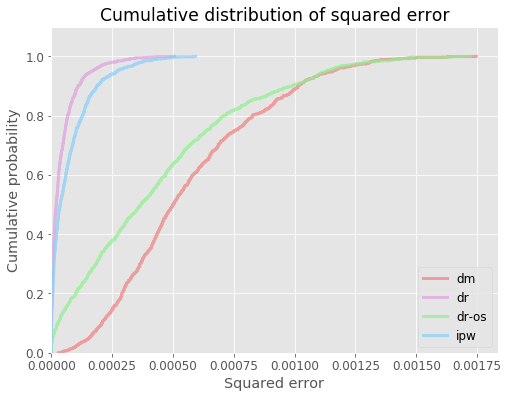

In [14]:
# visualize cdf of squared errors for all ope estimators
evaluator.visualize_cdf_aggregate()

In [15]:
# compute the au-cdf score (area under cdf of squared error over interval [0, thershold]), higher score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
au_cdf = evaluator.calculate_au_cdf_score(threshold=0.0004)
au_cdf

{'dm': 4.842819420579869e-05,
 'dr': 0.00035661732117858394,
 'dr-os': 0.0001248944509629071,
 'ipw': 0.0003274020016774632}

In [16]:
# by activating the `scale` option, 
# we obtain the au_cdf scores where the highest score is scaled to 1
au_cdf_scaled = evaluator.calculate_au_cdf_score(threshold=0.0004, scale=True)
au_cdf_scaled

{'dm': 0.13579877176394137,
 'dr': 1.0,
 'dr-os': 0.35021981139374736,
 'ipw': 0.9180765549901865}

In [17]:
# compute the cvar score (expected value of squared error above probability alpha), lower score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
cvar = evaluator.calculate_cvar_score(alpha=90)
cvar

{'dm': 0.0011913026755765136,
 'dr': 0.00019435043271928454,
 'dr-os': 0.0011808587841598175,
 'ipw': 0.00029734974429545586}

In [18]:
# by activating the `scale` option, 
# we obtain the cvar scores where the lowest score is scaled to 1
cvar_scaled = evaluator.calculate_cvar_score(alpha=90, scale=True)
cvar_scaled

{'dm': 6.12966309829217,
 'dr': 1.0,
 'dr-os': 6.075925675274537,
 'ipw': 1.529966978385591}

## Example 2 - Synthetic P-Score

A quickstart guide of pyIEOE using synthetic logged bandit feedback data and using estimated propensity scores of the behavior policy instead of the ground truth values.

This section demonstrates an example of conducting Interpretable Evaluation for Off-Policy Evaluation (IEOE). We use synthetic logged bandit feedback data generated using [`obp`](https://github.com/st-tech/zr-obp) and evaluate the performance of Direct Method (DM), Doubly Robust (DR), Doubly Robust with Shrinkage (DRos), and Inverse Probability Weighting (IPW).

Our example contains the following three major steps:

1. Data Preparation
2. Setting Hyperparameter Spaces for Off-Policy Evaluation
3. Interpretable Evaluation for Off-Policy Evaluation

### Data Preparation

In order to conduct IEOE using `pyieoe`, we need to prepare logged bandit feedback data, action distributions of evaluation policies, and ground truth policy values of evaluation policies. Because `pyieoe` is built with the intention of being used with `obp`, these inputs must follow the conventions in `obp`. Specifically, logged bandit feedback data must be of type `BanditFeedback`, action distributions must be of type `np.ndarray`, and ground truth policy values must be of type `float` (or `int`). 

In this example, we generate synthetic logged bandit feedback data and perform off-policy learning to obtain two sets of evaluation policies along with their action distributions and ground truth policy values using `obp`. For a detailed explanation of this process, please refer to the [official obp example](https://github.com/st-tech/zr-obp/blob/master/examples/quickstart/quickstart_synthetic.ipynb).

In [19]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345
)
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_train, n_rounds_test = 10000, 10000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

# define IPWLearner with Logistic Regression as its base ML model
evaluation_policy_a = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_a.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_a = evaluation_policy_a.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1 # temperature hyperparameter
)

# define IPWLearner with Random Forest as its base ML model
evaluation_policy_b = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_b.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_b = evaluation_policy_b.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1 # temperature hyperparameter
)

# obtain ground truth policy value for each action choice probabilities
expected_rewards = bandit_feedback_test["expected_reward"]
ground_truth_a = np.average(expected_rewards, weights=action_dist_a[:, :, 0], axis=1).mean()
ground_truth_b = np.average(expected_rewards, weights=action_dist_b[:, :, 0], axis=1).mean()

### Setting Hyperparameter Spaces for Off-Policy Evaluation

An integral aspect of IEOE is the different sources of variance. The main sources of variance are evaluation policies, random states, hyperparameters of OPE estimators, and hyperparameters of regression models. 

In this step, we define the spaces from which the hyperparameters of OPE estimators / regression models are chosen. (The evaluation policy space is defined in the previous step, and the random state space will be defined in the next step.)

In [20]:
# set hyperparameter space for ope estimators

# set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will be chosen from a logarithm uniform distribution over the interval [0.001, 1000]
lambda_ = {
    "lower": 1e-3,
    "upper": 1e3,
    "log": True,
    "type": float
}
dros_param = {"lambda_": lambda_}

In [21]:
# set hyperparameter space for regression models

# set hyperparameter space for logistic regression
# with the following code, C will be chosen from a logarithm uniform distribution over the interval [0.001, 100]
C = {
    "lower": 1e-3,
    "upper": 1e2,
    "log": True,
    "type": float
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
logistic_regression_param = {"C": C}

# set hyperparameter space for the random forest classifier
# with the following code, n_estimators will be chosen from a logarithm uniform distribution over the interval [50, 100]
# the chosen value will be of type int
n_estimators = {
    "lower": 5e1,
    "upper": 1e2,
    "log": True,
    "type": int
}
# with the following code, max_depth will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
max_depth = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# with the following code, min_samples_split will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
min_samples_split = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
random_forest_param = {
    "n_estimators": n_estimators, 
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split
}

### Interpretable Evaluation for Off-Policy Evaluation

With the above steps completed, we can finally conduct IEOE by utilizing the `InterpretableOPEEvaluator` class.

Here is a brief description for each parameter that can be passed into `InterpretableOPEEvaluator`:

- `random_states`: a list of integers representing the random_state used when performing OPE; corresponds to the number of iterations
- `bandit_feedback`: a list of logged bandit feedback data
- `evaluation_policies`: a list of tuples representing (ground truth policy value, action distribution)
- `ope_estimators`: a list of OPE ope_estimators
- `ope_estimator_hyperparams`: a dictionary mapping OPE estimator names to OPE estimator hyperparameter spaces defined in step 2
- `regression_models`: a list of regression_models
- `regression_model_hyperparams`: a dictionary mapping regression models to regression model hyperparameter spaces defined in step 2

In [22]:
# initializing class
evaluator = InterpretableOPEEvaluator(
    random_states=np.arange(1000),
    bandit_feedbacks=[bandit_feedback_test],
    evaluation_policies=[
        (ground_truth_a, action_dist_a), 
        (ground_truth_b, action_dist_b)
    ],
    ope_estimators=[
        DirectMethod(),
        DoublyRobust(),
        DoublyRobustWithShrinkage(),
        InverseProbabilityWeighting(), 
    ],
    ope_estimator_hyperparams={
        DoublyRobustWithShrinkage.estimator_name: dros_param,
    },
    regression_models=[
        LogisticRegression,
        RandomForest
    ],
    regression_model_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    },
    pscore_estimators=[
        LogisticRegression,
        RandomForest
    ],
    pscore_estimator_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    }
)

We can set the hyperparameters of OPE estimators / regression models after initializing `InterpretableOPEEvaluator` as well. Below is an example:

In [23]:
# re-set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_ope_estimator_hyperparam_space(
    DoublyRobustWithShrinkage.estimator_name,
    param_name="lambda_",
    lower=1e-3,
    upper=1e2,
    log=True,
    type_=float,
)

# re-set hyperparameter space for logistic regression
# with the following code, C will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_regression_model_hyperparam_space(
    LogisticRegression,
    param_name="C",
    lower=1e-2,
    upper=1e2,
    log=True,
    type_=float,
)

Once we have initialized `InterpretableOPEEvaluator`, we can call implemented methods to perform IEOE.

In [24]:
# estimate policy values
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the estimated policy value for each iteration
policy_value = evaluator.estimate_policy_value()

100%|██████████| 1000/1000 [24:26<00:00,  1.47s/it]


In [25]:
print("dm:", policy_value["dm"][:3])
print("dr:", policy_value["dr"][:3])
print("dr-os:", policy_value["dr-os"][:3])
print("ipw:", policy_value["ipw"][:3])

dm: [0.61928102 0.61815126 0.62100605]
dr: [0.63491063 0.62905724 0.63769723]
dr-os: [0.61845464 0.6172667  0.61979627]
ipw: [0.63454838 0.59634147 0.63845108]


In [26]:
# compute squared errors
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the calculated squared error for each iteration
squared_error = evaluator.calculate_squared_error()

In [27]:
print("dm:", squared_error["dm"][:3])
print("dr:", squared_error["dr"][:3])
print("dr-os:", squared_error["dr-os"][:3])
print("ipw:", squared_error["ipw"][:3])

dm: [0.00016377 0.00024432 0.0001226 ]
dr: [8.02190891e-06 2.23240194e-05 3.15720425e-05]
dr-os: [0.0001856  0.00027276 0.00015085]
ipw: [6.10115801e-06 1.40179838e-03 4.06119256e-05]


<Figure size 432x288 with 0 Axes>

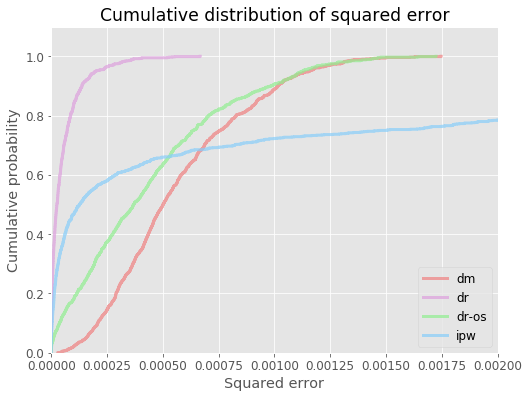

In [28]:
# visualize cdf of squared errors for all ope estimators
evaluator.visualize_cdf_aggregate(xmax=0.002)

In [29]:
# compute the au-cdf score (area under cdf of squared error over interval [0, thershold]), higher score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
au_cdf = evaluator.calculate_au_cdf_score(threshold=0.0004)
au_cdf

{'dm': 4.842819420579869e-05,
 'dr': 0.0003466009625279595,
 'dr-os': 0.00012101638056751279,
 'ipw': 0.00020585995217926292}

In [30]:
# by activating the `scale` option, 
# we obtain the au_cdf scores where the highest score is scaled to 1
au_cdf_scaled = evaluator.calculate_au_cdf_score(threshold=0.0004, scale=True)
au_cdf_scaled

{'dm': 0.13972319595590305,
 'dr': 1.0,
 'dr-os': 0.34915188834119487,
 'ipw': 0.5939393551529929}

In [31]:
# compute the cvar score (expected value of squared error above probability alpha), lower score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
cvar = evaluator.calculate_cvar_score(alpha=90)
cvar

{'dm': 0.0011913026755765136,
 'dr': 0.0002413591310464852,
 'dr-os': 0.0011775829027122176,
 'ipw': 0.006564340612263946}

In [32]:
# by activating the `scale` option, 
# we obtain the cvar scores where the lowest score is scaled to 1
cvar_scaled = evaluator.calculate_cvar_score(alpha=90, scale=True)
cvar_scaled

{'dm': 4.93580943224009,
 'dr': 1.0,
 'dr-os': 4.878965621091078,
 'ipw': 27.19739909487688}

## Example 3 - Synthetic RSCV

A quickstart guide of pyIEOE using synthetic logged bandit feedback data and using RandomizedSearchCV for regression models and pscore estimators.

### Data Preparation

In order to conduct IEOE using `pyieoe`, we need to prepare logged bandit feedback data, action distributions of evaluation policies, and ground truth policy values of evaluation policies. Because `pyieoe` is built with the intention of being used with `obp`, these inputs must follow the conventions in `obp`. Specifically, logged bandit feedback data must be of type `BanditFeedback`, action distributions must be of type `np.ndarray`, and ground truth policy values must be of type `float` (or `int`). 

In this example, we generate synthetic logged bandit feedback data and perform off-policy learning to obtain two sets of evaluation policies along with their action distributions and ground truth policy values using `obp`. For a detailed explanation of this process, please refer to the [official obp example](https://github.com/st-tech/zr-obp/blob/master/examples/quickstart/quickstart_synthetic.ipynb).

In [ ]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345
)
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_train, n_rounds_test = 10000, 10000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

# define IPWLearner with Logistic Regression as its base ML model
evaluation_policy_a = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_a.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_a = evaluation_policy_a.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1 # temperature hyperparameter
)

# define IPWLearner with Random Forest as its base ML model
evaluation_policy_b = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
evaluation_policy_b.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_b = evaluation_policy_b.predict_proba(
    context=bandit_feedback_test["context"],
    tau=0.1 # temperature hyperparameter
)

# obtain ground truth policy value for each action choice probabilities
expected_rewards = bandit_feedback_test["expected_reward"]
ground_truth_a = np.average(expected_rewards, weights=action_dist_a[:, :, 0], axis=1).mean()
ground_truth_b = np.average(expected_rewards, weights=action_dist_b[:, :, 0], axis=1).mean()

### Setting Hyperparameter Spaces for Off-Policy Evaluation

An integral aspect of IEOE is the different sources of variance. The main sources of variance are evaluation policies, random states, hyperparameters of OPE estimators, and hyperparameters of regression models. 

In this step, we define the spaces from which the hyperparameters of OPE estimators / regression models are chosen. (The evaluation policy space is defined in the previous step, and the random state space will be defined in the next step.)

In [ ]:
# set hyperparameter space for ope estimators

# set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will be chosen from a logarithm uniform distribution over the interval [0.001, 1000]
lambda_ = {
    "lower": 1e-3,
    "upper": 1e3,
    "log": True,
    "type": float
}
dros_param = {"lambda_": lambda_}

In [ ]:
# set hyperparameter space for logistic regression using RandomizedSearchCV

from sklearn.utils.fixes import loguniform
logistic = LogisticRegression()
distributions = {
    "C": loguniform(1e-2, 1e2)
}
clf_logistic = RandomizedSearchCV(logistic, distributions, random_state=0, n_iter=5)

In [ ]:
# set hyperparameter space for random forest classifier using RandomizedSearchCV

from scipy.stats import randint
randforest = RandomForest()
distributions = {
    # n_estimators will be chosen from a uniform distribution over the interval [50, 100)
    "n_estimators": randint(5e1, 1e2), 
    # max_depth will be chosen from a uniform distribution over the interval [2, 10)
    "max_depth": randint(2, 10), 
    # min_samples_split will be chosen from a uniform distribution over the interval [2, 10)
    "min_samples_split": randint(2, 10)
}
clf_randforest = RandomizedSearchCV(randforest, distributions, random_state=0, n_iter=5)

### Interpretable Evaluation for Off-Policy Evaluation

With the above steps completed, we can finally conduct IEOE by utilizing the `InterpretableOPEEvaluator` class.

Here is a brief description for each parameter that can be passed into `InterpretableOPEEvaluator`:

- `random_states`: a list of integers representing the random_state used when performing OPE; corresponds to the number of iterations
- `bandit_feedback`: a list of logged bandit feedback data
- `evaluation_policies`: a list of tuples representing (ground truth policy value, action distribution)
- `ope_estimators`: a list of OPE ope_estimators
- `ope_estimator_hyperparams`: a dictionary mapping OPE estimator names to OPE estimator hyperparameter spaces defined in step 2
- `regression_models`: a list of regression_models
- `regression_model_hyperparams`: a dictionary mapping regression models to regression model hyperparameter spaces defined in step 2

In [ ]:
# initializing class
evaluator = InterpretableOPEEvaluator(
    random_states=np.arange(100),
    bandit_feedbacks=[bandit_feedback_test],
    evaluation_policies=[
        (ground_truth_a, action_dist_a), 
        (ground_truth_b, action_dist_b)
    ],
    ope_estimators=[
        DirectMethod(),
        DoublyRobust(),
        DoublyRobustWithShrinkage(),
        InverseProbabilityWeighting(), 
    ],
    ope_estimator_hyperparams={
        DoublyRobustWithShrinkage.estimator_name: dros_param,
    },
    regression_models=[
        clf_logistic,
        clf_randforest
    ],
    pscore_estimators=[
        clf_logistic,
        clf_randforest
    ]
)

Once we have initialized `InterpretableOPEEvaluator`, we can call implemented methods to perform IEOE.

In [ ]:
# estimate policy values
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the estimated policy value for each iteration
policy_value = evaluator.estimate_policy_value()

100%|██████████| 100/100 [42:58<00:00, 25.78s/it] 


In [ ]:
print("dm:", policy_value["dm"][:3])
print("dr:", policy_value["dr"][:3])
print("dr-os:", policy_value["dr-os"][:3])
print("ipw:", policy_value["ipw"][:3])

dm: [0.61533497 0.62502863 0.62595308]
dr: [0.63454837 0.6498667  0.64764559]
dr-os: [0.61847981 0.62353027 0.62459582]
ipw: [0.63682535 0.6512438  0.6464395 ]


In [ ]:
# compute squared errors
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the calculated squared error for each iteration
squared_error = evaluator.calculate_squared_error()

In [ ]:
print("dm:", squared_error["dm"][:3])
print("dr:", squared_error["dr"][:3])
print("dr-os:", squared_error["dr-os"][:3])
print("ipw:", squared_error["ipw"][:3])

dm: [3.57123403e-04 7.67642667e-05 6.85517345e-05]
dr: [9.96635880e-08 2.58455440e-04 1.79906369e-04]
dr-os: [2.48152724e-04 1.05265196e-04 9.28690429e-05]
ipw: [6.72196710e-06 3.04629826e-04 1.49006452e-04]


<Figure size 432x288 with 0 Axes>

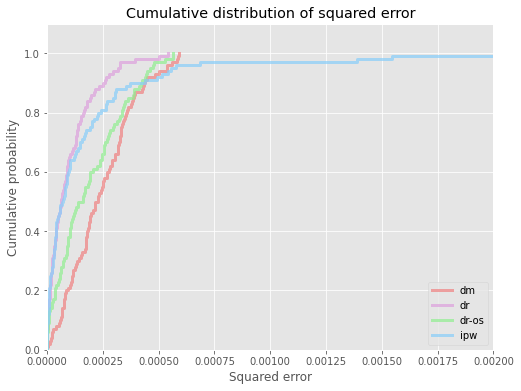

In [ ]:
# visualize cdf of squared errors for all ope estimators
evaluator.visualize_cdf_aggregate(xmax=0.002)

In [ ]:
# compute the au-cdf score (area under cdf of squared error over interval [0, thershold]), higher score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
au_cdf = evaluator.calculate_au_cdf_score(threshold=0.0004)
au_cdf

{'dm': 0.00017462629944369262,
 'dr': 0.0003039477544441512,
 'dr-os': 0.00022192684331982026,
 'ipw': 0.00027946158685387886}

In [ ]:
# by activating the `scale` option, 
# we obtain the au_cdf scores where the highest score is scaled to 1
au_cdf_scaled = evaluator.calculate_au_cdf_score(threshold=0.0004, scale=True)
au_cdf_scaled

{'dm': 0.5745273550812803,
 'dr': 1.0,
 'dr-os': 0.7301479944330306,
 'ipw': 0.9194395509351541}

In [ ]:
# compute the cvar score (expected value of squared error above probability alpha), lower score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
cvar = evaluator.calculate_cvar_score(alpha=90)
cvar

{'dm': 0.0005265251431511972,
 'dr': 0.00035002638397540044,
 'dr-os': 0.00048265567771403026,
 'ipw': 0.001182280933254418}

In [ ]:
# by activating the `scale` option, 
# we obtain the cvar scores where the lowest score is scaled to 1
cvar_scaled = evaluator.calculate_cvar_score(alpha=90, scale=True)
cvar_scaled

{'dm': 1.5042441577438372,
 'dr': 1.0,
 'dr-os': 1.3789122757899042,
 'ipw': 3.3776909038305742}

## Example 4 - Multiclass dataset

A quickstart guide of pyIEOE using multiclass classification data as logged bandit feedback data.

This section demonstrates an example of conducting Interpretable Evaluation for Off-Policy Evaluation (IEOE). We use logged bandit feedback data generated by modifying multiclass classification data using [`obp`](https://github.com/st-tech/zr-obp) and evaluate the performance of Direct Method (DM), Doubly Robust (DR), Doubly Robust with Shrinkage (DRos), and Inverse Probability Weighting (IPW).

Our example contains the following three major steps:

1. Data Preparation
2. Setting Hyperparameter Spaces for Off-Policy Evaluation
3. Interpretable Evaluation for Off-Policy Evaluation

### Data Preparation

In order to conduct IEOE using `pyieoe`, we need to prepare logged bandit feedback data, action distributions of evaluation policies, and ground truth policy values of evaluation policies. Because `pyieoe` is built with the intention of being used with `obp`, these inputs must follow the conventions in `obp`. Specifically, logged bandit feedback data must be of type `BanditFeedback`, action distributions must be of type `np.ndarray`, and ground truth policy values must be of type `float` (or `int`). 

In this example, we generate logged bandit feedback data by modifying multiclass classification data and obtain two sets of evaluation policies along with their action distributions and ground truth policy values using `obp`. For a detailed explanation of this process, please refer to the [official docs](https://zr-obp.readthedocs.io/en/latest/_autosummary/obp.dataset.multiclass.html#module-obp.dataset.multiclass).

In [ ]:
# load raw digits data
X, y = load_digits(return_X_y=True)
# convert the raw classification data into the logged bandit dataset
dataset = MultiClassToBanditReduction(
    X=X,
    y=y,
    base_classifier_b=LogisticRegression(random_state=12345),
    alpha_b=0.8,
    dataset_name="digits"
)
# split the original data into the training and evaluation sets
dataset.split_train_eval(eval_size=0.7, random_state=12345)
# obtain logged bandit feedback generated by the behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=12345)

# obtain action choice probabilities by an evaluation policy and its ground-truth policy value
action_dist_a = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=LogisticRegression(C=100, random_state=12345),
    alpha_e=0.9
)
ground_truth_a = dataset.calc_ground_truth_policy_value(action_dist=action_dist_a)
action_dist_b = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForest(n_estimators=100, min_samples_split=5, random_state=12345),
    alpha_e=0.9
)
ground_truth_b = dataset.calc_ground_truth_policy_value(action_dist=action_dist_b)

### Setting Hyperparameter Spaces for Off-Policy Evaluation

An integral aspect of IEOE is the different sources of variance. The main sources of variance are evaluation policies, random states, hyperparameters of OPE estimators, and hyperparameters of regression models. 

In this step, we define the spaces from which the hyperparameters of OPE estimators / regression models are chosen. (The evaluation policy space is defined in the previous step, and the random state space will be defined in the next step.)

In [ ]:
# set hyperparameter space for ope estimators

# set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will be chosen from a logarithm uniform distribution over the interval [0.001, 1000]
lambda_ = {
    "lower": 1e-3,
    "upper": 1e3,
    "log": True,
    "type": float
}
dros_param = {"lambda_": lambda_}

In [ ]:
# set hyperparameter space for regression models

# set hyperparameter space for logistic regression
# with the following code, C will be chosen from a logarithm uniform distribution over the interval [0.001, 100]
C = {
    "lower": 1e-3,
    "upper": 1e2,
    "log": True,
    "type": float
}
# with the following code, max_iter will be fixed at 10000 and of type int
max_iter = {
    "lower": 1e4,
    "upper": 1e4,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
logistic_regression_param = {
    "C": C,
    "max_iter": max_iter
}

# set hyperparameter space for random forest classifier
# with the following code, n_estimators will be chosen from a logarithm uniform distribution over the interval [50, 100]
# the chosen value will be of type int
n_estimators = {
    "lower": 5e1,
    "upper": 1e2,
    "log": True,
    "type": int
}
# with the following code, max_depth will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
max_depth = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# with the following code, min_samples_split will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
min_samples_split = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
random_forest_param = {
    "n_estimators": n_estimators, 
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split
}

### Interpretable Evaluation for Off-Policy Evaluation

With the above steps completed, we can finally conduct IEOE by utilizing the `InterpretableOPEEvaluator` class.

Here is a brief description for each parameter that can be passed into `InterpretableOPEEvaluator`:

- `random_states`: a list of integers representing the random_state used when performing OPE; corresponds to the number of iterations
- `bandit_feedback`: a list of logged bandit feedback data
- `evaluation_policies`: a list of tuples representing (ground truth policy value, action distribution)
- `ope_estimators`: a list of OPE ope_estimators
- `ope_estimator_hyperparams`: a dictionary mapping OPE estimator names to OPE estimator hyperparameter spaces defined in step 2
- `regression_models`: a list of regression regression_models
- `regression_model_hyperparams`: a dictionary mapping regression models to regression model hyperparameter spaces defined in step 2

In [ ]:
# initializing class
evaluator = InterpretableOPEEvaluator(
    random_states=np.arange(1000),
    bandit_feedbacks=[bandit_feedback],
    evaluation_policies=[
        (ground_truth_a, action_dist_a), 
        (ground_truth_b, action_dist_b)
    ],
    ope_estimators=[
        DirectMethod(),
        DoublyRobust(),
        DoublyRobustWithShrinkage(),
        InverseProbabilityWeighting(), 
    ],
    ope_estimator_hyperparams={
        DoublyRobustWithShrinkage.estimator_name: dros_param,
    },
    regression_models=[
        LogisticRegression,
        RandomForest
    ],
    regression_model_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    }
)

We can set the hyperparameters of OPE estimators / regression models after initializing `InterpretableOPEEvaluator` as well. Below is an example:

In [ ]:
# re-set hyperparameter space for doubly robust with shrinkage estimator
# with the following code, lambda_ will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_ope_estimator_hyperparam_space(
    DoublyRobustWithShrinkage.estimator_name,
    param_name="lambda_",
    lower=1e-3,
    upper=1e2,
    log=True,
    type_=float,
)

# re-set hyperparameter space for logistic regression
# with the following code, C will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_regression_model_hyperparam_space(
    LogisticRegression,
    param_name="C",
    lower=1e-2,
    upper=1e2,
    log=True,
    type_=float,
)

Once we have initialized `InterpretableOPEEvaluator`, we can call implemented methods to perform IEOE.

In [ ]:
# estimate policy values
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the estimated policy value for each iteration
policy_value = evaluator.estimate_policy_value()

100%|██████████| 1000/1000 [11:17<00:00,  1.48it/s]


In [ ]:
print("dm:", policy_value["dm"][:3])
print("dr:", policy_value["dr"][:3])
print("dr-os:", policy_value["dr-os"][:3])
print("ipw:", policy_value["ipw"][:3])

dm: [0.81134402 0.78412865 0.78674876]
dr: [0.86480653 0.85936748 0.86395919]
dr-os: [0.81064521 0.77765542 0.7784058 ]
ipw: [0.87521812 0.88807243 0.8636725 ]


In [ ]:
# compute squared errors
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the calculated squared error for each iteration
squared_error = evaluator.calculate_squared_error()

In [ ]:
print("dm:", squared_error["dm"][:3])
print("dr:", squared_error["dr"][:3])
print("dr-os:", squared_error["dr-os"][:3])
print("ipw:", squared_error["ipw"][:3])

dm: [0.00294847 0.00748626 0.00622444]
dr: [7.01161709e-07 1.27336628e-04 2.83816202e-06]
dr-os: [0.00302485 0.00864833 0.00761048]
ipw: [9.16660156e-05 3.03477502e-04 3.88635152e-06]


<Figure size 432x288 with 0 Axes>

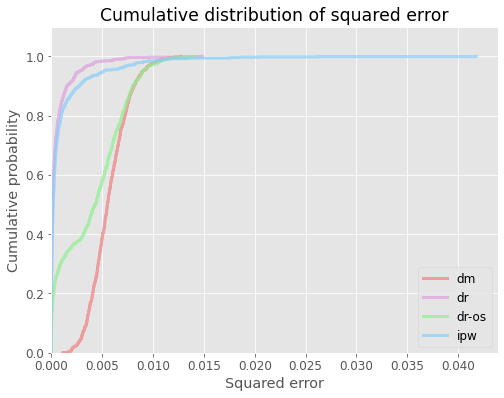

In [ ]:
# visualize cdf of squared errors for all ope estimators
evaluator.visualize_cdf_aggregate()

In [ ]:
# compute the au-cdf score (area under cdf of squared error over interval [0, thershold]), higher score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
au_cdf = evaluator.calculate_au_cdf_score(threshold=0.004)
au_cdf

{'dm': 0.00014444454239821147,
 'dr': 0.0034740129891242164,
 'dr-os': 0.001371870093647186,
 'ipw': 0.0032895493305153413}

In [ ]:
# by activating the `scale` option, 
# we obtain au_cdf scores where the highest score is scaled to 1
au_cdf_scaled = evaluator.calculate_au_cdf_score(threshold=0.004, scale=True)
au_cdf_scaled

{'dm': 0.04157858443546733,
 'dr': 1.0,
 'dr-os': 0.3948949235198538,
 'ipw': 0.9469018512059802}

In [ ]:
# compute the cvar score (expected value of squared error above probability alpha), lower score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
cvar = evaluator.calculate_cvar_score(alpha=90)
cvar

{'dm': 0.00936181325035828,
 'dr': 0.003630139850166714,
 'dr-os': 0.009520288490655431,
 'ipw': 0.006955857378145971}

In [ ]:
# by activating the `scale` option, 
# we obtain cvar scores where the lowest score is scaled to 1
cvar_scaled = evaluator.calculate_cvar_score(alpha=90, scale=True)
cvar_scaled

{'dm': 2.578912558955088,
 'dr': 1.0,
 'dr-os': 2.622567968068286,
 'ipw': 1.9161403321215087}

## Example 5 - Multiclass P-Score

A quickstart guide of pyIEOE using multiclass classification data and using estimated propensity scores of the behavior policy instead of the ground truth values.

This notebook demonstrates an example of conducting Interpretable Evaluation for Off-Policy Evaluation (IEOE). We use logged bandit feedback data generated by modifying multiclass classification data using [`obp`](https://github.com/st-tech/zr-obp) and evaluate the performance of Direct Method (DM), Doubly Robust (DR), Doubly Robust with Shrinkage (DRos), and Inverse Probability Weighting (IPW).

Our example contains the following three major steps:

1. Data Preparation
2. Setting Hyperparameter Spaces for Off-Policy Evaluation
3. Interpretable Evaluation for Off-Policy Evaluation

### Data Preparation

In order to conduct IEOE using `pyieoe`, we need to prepare logged bandit feedback data, action distributions of evaluation policies, and ground truth policy values of evaluation policies. Because `pyieoe` is built with the intention of being used with `obp`, these inputs must follow the conventions in `obp`. Specifically, logged bandit feedback data must be of type `BanditFeedback`, action distributions must be of type `np.ndarray`, and ground truth policy values must be of type `float` (or `int`). 

In this example, we generate logged bandit feedback data by modifying multiclass classification data and obtain two sets of evaluation policies along with their action distributions and ground truth policy values using `obp`. For a detailed explanation of this process, please refer to the [official docs](https://zr-obp.readthedocs.io/en/latest/_autosummary/obp.dataset.multiclass.html#module-obp.dataset.multiclass).

In [ ]:
# load raw digits data
X, y = load_digits(return_X_y=True)
# convert the raw classification data into the logged bandit dataset
dataset = MultiClassToBanditReduction(
    X=X,
    y=y,
    base_classifier_b=LogisticRegression(random_state=12345),
    alpha_b=0.8,
    dataset_name="digits"
)
# split the original data into the training and evaluation sets
dataset.split_train_eval(eval_size=0.7, random_state=12345)
# obtain logged bandit feedback generated by the behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=12345)

# obtain action choice probabilities by an evaluation policy and its ground-truth policy value
action_dist_a = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=LogisticRegression(C=100, random_state=12345, max_iter=10000),
    alpha_e=0.9
)
ground_truth_a = dataset.calc_ground_truth_policy_value(action_dist=action_dist_a)
action_dist_b = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForest(n_estimators=100, min_samples_split=5, random_state=12345),
    alpha_e=0.9
)
ground_truth_b = dataset.calc_ground_truth_policy_value(action_dist=action_dist_b)

### Setting Hyperparameter Spaces for Off-Policy Evaluation

An integral aspect of IEOE is the different sources of variance. The main sources of variance are evaluation policies, random states, hyperparameters of OPE estimators, and hyperparameters of regression models. 

In this step, we define the spaces from which the hyperparameters of OPE estimators / regression models are chosen. (The evaluation policy space is defined in the previous step, and the random state space will be defined in the next step.)

In [ ]:
# set hyperparameter space for ope estimators

# set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will be chosen from a logarithm uniform distribution over the interval [0.001, 1000]
lambda_ = {
    "lower": 1e-3,
    "upper": 1e3,
    "log": True,
    "type": float
}
dros_param = {"lambda_": lambda_}

In [ ]:
# set hyperparameter space for regression models

# set hyperparameter space for logistic regression
# with the following code, C will be chosen from a logarithm uniform distribution over the interval [0.001, 100]
# the chosen value will be of type float
C = {
    "lower": 1e-3,
    "upper": 1e2,
    "log": True,
    "type": float
}
# with the following code, max_iter will be fixed at 10000 and of type int
max_iter = {
    "lower": 1e4,
    "upper": 1e4,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
logistic_regression_param = {
    "C": C,
    "max_iter": max_iter
}

# set hyperparameter space for random forest classifier
# with the following code, n_estimators will be chosen from a logarithm uniform distribution over the interval [50, 100]
# the chosen value will be of type int
n_estimators = {
    "lower": 5e1,
    "upper": 1e2,
    "log": True,
    "type": int
}
# with the following code, max_depth will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
max_depth = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# with the following code, min_samples_split will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
min_samples_split = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
random_forest_param = {
    "n_estimators": n_estimators, 
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split
}

### Interpretable Evaluation for Off-Policy Evaluation

With the above steps completed, we can finally conduct IEOE by utilizing the `InterpretableOPEEvaluator` class.

Here is a brief description for each parameter that can be passed into `InterpretableOPEEvaluator`:

- `random_states`: a list of integers representing the random_state used when performing OPE; corresponds to the number of iterations
- `bandit_feedback`: a list of logged bandit feedback data
- `evaluation_policies`: a list of tuples representing (ground truth policy value, action distribution)
- `ope_estimators`: a list of OPE ope_estimators
- `ope_estimator_hyperparams`: a dictionary mapping OPE estimator names to OPE estimator hyperparameter spaces defined in step 2
- `regression_models`: a list of regression regression_models
- `regression_model_hyperparams`: a dictionary mapping regression models to regression model hyperparameter spaces defined in step 2

In [ ]:
# initializing class
evaluator = InterpretableOPEEvaluator(
    random_states=np.arange(1000),
    bandit_feedbacks=[bandit_feedback],
    evaluation_policies=[
        (ground_truth_a, action_dist_a), 
        (ground_truth_b, action_dist_b)
    ],
    ope_estimators=[
        DirectMethod(),
        DoublyRobust(),
        DoublyRobustWithShrinkage(),
        InverseProbabilityWeighting(), 
    ],
    ope_estimator_hyperparams={
        DoublyRobustWithShrinkage.estimator_name: dros_param,
    },
    regression_models=[
        LogisticRegression,
        RandomForest
    ],
    regression_model_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    },
    pscore_estimators=[
        LogisticRegression,
        RandomForest
    ],
    pscore_estimator_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    }
)

We can set the hyperparameters of OPE estimators / regression models after initializing `InterpretableOPEEvaluator` as well. Below is an example:

In [ ]:
# re-set hyperparameter space for doubly robust with shrinkage estimator
# with the following code, lambda_ will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_ope_estimator_hyperparam_space(
    DoublyRobustWithShrinkage.estimator_name,
    param_name="lambda_",
    lower=1e-3,
    upper=1e2,
    log=True,
    type_=float,
)

# re-set hyperparameter space for logistic regression
# with the following code, C will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_regression_model_hyperparam_space(
    LogisticRegression,
    param_name="C",
    lower=1e-2,
    upper=1e2,
    log=True,
    type_=float,
)

Once we have initialized `InterpretableOPEEvaluator`, we can call implemented methods to perform IEOE.

In [ ]:
# estimate policy values
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the estimated policy value for each iteration
policy_value = evaluator.estimate_policy_value()

100%|██████████| 1000/1000 [35:36<00:00,  2.14s/it] 


In [ ]:
print("dm:", policy_value["dm"][:3])
print("dr:", policy_value["dr"][:3])
print("dr-os:", policy_value["dr-os"][:3])
print("ipw:", policy_value["ipw"][:3])

dm: [0.81096739 0.78412865 0.78712081]
dr: [0.8253112  1.00228582 0.78789132]
dr-os: [0.82473807 0.78602363 0.78783993]
ipw: [1.01482753 1.11752925 1.0182291 ]


In [ ]:
# compute squared errors
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the calculated squared error for each iteration
squared_error = evaluator.calculate_squared_error()

In [ ]:
print("dm:", squared_error["dm"][:3])
print("dr:", squared_error["dr"][:3])
print("dr-os:", squared_error["dr-os"][:3])
print("ipw:", squared_error["ipw"][:3])

dm: [0.00253854 0.00748626 0.00551017]
dr: [0.00129889 0.01732751 0.00539638]
dr-os: [0.00134053 0.00716193 0.00540393]
ipw: [0.02355494 0.06094846 0.02461063]


<Figure size 432x288 with 0 Axes>

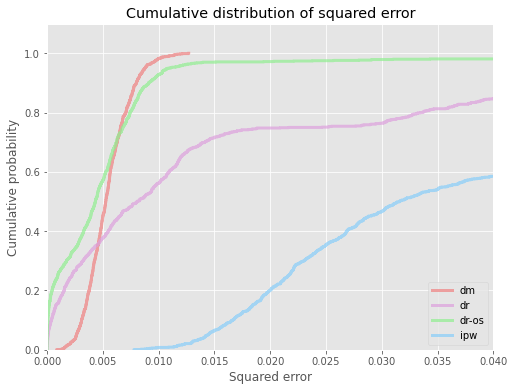

In [ ]:
# visualize cdf of squared errors for all ope estimators
evaluator.visualize_cdf_aggregate(xmax=0.04)

In [ ]:
# compute the au-cdf score (area under cdf of squared error over interval [0, thershold]), higher score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
au_cdf = evaluator.calculate_au_cdf_score(threshold=0.004)
au_cdf

{'dm': 0.00021056405032585993,
 'dr': 0.0008879177361003537,
 'dr-os': 0.001237122081750088,
 'ipw': 0.0}

In [ ]:
# by activating the `scale` option, 
# we obtain au_cdf scores where the highest score is scaled to 1
au_cdf_scaled = evaluator.calculate_au_cdf_score(threshold=0.004, scale=True)
au_cdf_scaled

{'dm': 0.17020474650972736, 'dr': 0.71772846770649, 'dr-os': 1.0, 'ipw': 0.0}

In [ ]:
# compute the cvar score (expected value of squared error above probability alpha), lower score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
cvar = evaluator.calculate_cvar_score(alpha=90)
cvar

{'dm': 0.009140229299153585,
 'dr': 0.16904269955964735,
 'dr-os': 0.024619638962354397,
 'ipw': 3.111787619643494}

In [ ]:
# by activating the `scale` option, 
# we obtain cvar scores where the lowest score is scaled to 1
cvar_scaled = evaluator.calculate_cvar_score(alpha=90, scale=True)
cvar_scaled

{'dm': 1.0,
 'dr': 18.494360921043988,
 'dr-os': 2.6935471919325105,
 'ipw': 340.44962306707725}

## Example 6 - Multiclass RSCV

A quickstart guide of pyIEOE using multiclass classification data and using RandomizedSearchCV for regression models and pscore estimators.

This section demonstrates an example of conducting Interpretable Evaluation for Off-Policy Evaluation (IEOE). We use logged bandit feedback data generated by modifying multiclass classification data using [`obp`](https://github.com/st-tech/zr-obp) and evaluate the performance of Direct Method (DM), Doubly Robust (DR), Doubly Robust with Shrinkage (DRos), and Inverse Probability Weighting (IPW).

Our example contains the following three major steps:

1. Data Preparation
2. Setting Hyperparameter Spaces for Off-Policy Evaluation
3. Interpretable Evaluation for Off-Policy Evaluation

### Data Preparation

In order to conduct IEOE using `pyieoe`, we need to prepare logged bandit feedback data, action distributions of evaluation policies, and ground truth policy values of evaluation policies. Because `pyieoe` is built with the intention of being used with `obp`, these inputs must follow the conventions in `obp`. Specifically, logged bandit feedback data must be of type `BanditFeedback`, action distributions must be of type `np.ndarray`, and ground truth policy values must be of type `float` (or `int`). 

In this example, we generate logged bandit feedback data by modifying multiclass classification data and obtain two sets of evaluation policies along with their action distributions and ground truth policy values using `obp`. For a detailed explanation of this process, please refer to the [official docs](https://zr-obp.readthedocs.io/en/latest/_autosummary/obp.dataset.multiclass.html#module-obp.dataset.multiclass).

In [ ]:
# load raw digits data
X, y = load_digits(return_X_y=True)
# convert the raw classification data into the logged bandit dataset
dataset = MultiClassToBanditReduction(
    X=X,
    y=y,
    base_classifier_b=LogisticRegression(random_state=12345),
    alpha_b=0.8,
    dataset_name="digits"
)
# split the original data into the training and evaluation sets
dataset.split_train_eval(eval_size=0.7, random_state=12345)
# obtain logged bandit feedback generated by the behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=12345)

# obtain action choice probabilities by an evaluation policy and its ground-truth policy value
action_dist_a = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=LogisticRegression(C=100, random_state=12345, max_iter=10000),
    alpha_e=0.9
)
ground_truth_a = dataset.calc_ground_truth_policy_value(action_dist=action_dist_a)
action_dist_b = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForest(n_estimators=100, min_samples_split=5, random_state=12345),
    alpha_e=0.9
)
ground_truth_b = dataset.calc_ground_truth_policy_value(action_dist=action_dist_b)

### Setting Hyperparameter Spaces for Off-Policy Evaluation

An integral aspect of IEOE is the different sources of variance. The main sources of variance are evaluation policies, random states, hyperparameters of OPE estimators, and hyperparameters of regression models. 

In this step, we define the spaces from which the hyperparameters of OPE estimators / regression models are chosen. (The evaluation policy space is defined in the previous step, and the random state space will be defined in the next step.)

In [ ]:
# set hyperparameter space for ope estimators

# set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will be chosen from a logarithm uniform distribution over the interval [0.001, 1000]
lambda_ = {
    "lower": 1e-3,
    "upper": 1e3,
    "log": True,
    "type": float
}
dros_param = {"lambda_": lambda_}

In [ ]:
# set hyperparameter space for logistic regression using RandomizedSearchCV

from sklearn.utils.fixes import loguniform
logistic = LogisticRegression()
distributions = {
    "C": loguniform(1e-2, 1e2)
}
clf_logistic = RandomizedSearchCV(logistic, distributions, random_state=0, n_iter=5)

In [ ]:
# set hyperparameter space for random forest classifier using RandomizedSearchCV

from scipy.stats import randint
randforest = RandomForest()
distributions = {
    # n_estimators will be chosen from a uniform distribution over the interval [50, 100)
    "n_estimators": randint(5e1, 1e2), 
    # max_depth will be chosen from a uniform distribution over the interval [2, 10)
    "max_depth": randint(2, 10), 
    # min_samples_split will be chosen from a uniform distribution over the interval [2, 10)
    "min_samples_split": randint(2, 10)
}
clf_randforest = RandomizedSearchCV(randforest, distributions, random_state=0, n_iter=5)

### Interpretable Evaluation for Off-Policy Evaluation

With the above steps completed, we can finally conduct IEOE by utilizing the `InterpretableOPEEvaluator` class.

Here is a brief description for each parameter that can be passed into `InterpretableOPEEvaluator`:

- `random_states`: a list of integers representing the random_state used when performing OPE; corresponds to the number of iterations
- `bandit_feedback`: a list of logged bandit feedback data
- `evaluation_policies`: a list of tuples representing (ground truth policy value, action distribution)
- `ope_estimators`: a list of OPE ope_estimators
- `ope_estimator_hyperparams`: a dictionary mapping OPE estimator names to OPE estimator hyperparameter spaces defined in step 2
- `regression_models`: a list of regression regression_models
- `regression_model_hyperparams`: a dictionary mapping regression models to regression model hyperparameter spaces defined in step 2

In [ ]:
# initializing class
evaluator = InterpretableOPEEvaluator(
    random_states=np.arange(100),
    bandit_feedbacks=[bandit_feedback],
    evaluation_policies=[
        (ground_truth_a, action_dist_a), 
        (ground_truth_b, action_dist_b)
    ],
    ope_estimators=[
        DirectMethod(),
        DoublyRobust(),
        DoublyRobustWithShrinkage(),
        InverseProbabilityWeighting(), 
    ],
    ope_estimator_hyperparams={
        DoublyRobustWithShrinkage.estimator_name: dros_param,
    },
    regression_models=[
        clf_logistic,
        clf_randforest
    ],
    pscore_estimators=[
        clf_logistic,
        clf_randforest
    ]
)

Once we have initialized `InterpretableOPEEvaluator`, we can call implemented methods to perform IEOE.

In [ ]:
# estimate policy values
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the estimated policy value for each iteration
policy_value = evaluator.estimate_policy_value()

100%|██████████| 100/100 [16:46<00:00, 10.07s/it]


In [ ]:
print("dm:", policy_value["dm"][:3])
print("dr:", policy_value["dr"][:3])
print("dr-os:", policy_value["dr-os"][:3])
print("ipw:", policy_value["ipw"][:3])

dm: [0.81742383 0.78314456 0.78401187]
dr: [0.82105688 0.99782594 0.84922517]
dr-os: [0.83782131 0.80315577 0.79384228]
ipw: [1.02730624 1.08930531 1.03776308]


In [ ]:
# compute squared errors
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the calculated squared error for each iteration
squared_error = evaluator.calculate_squared_error()

In [ ]:
print("dm:", squared_error["dm"][:3])
print("dr:", squared_error["dr"][:3])
print("dr-os:", squared_error["dr-os"][:3])
print("ipw:", squared_error["ipw"][:3])

dm: [0.00192963 0.00765752 0.0059814 ]
dr: [0.00162364 0.01617325 0.00014704]
dr-os: [0.00055366 0.00455572 0.00455747]
ipw: [0.02754103 0.04780934 0.0311211 ]


<Figure size 432x288 with 0 Axes>

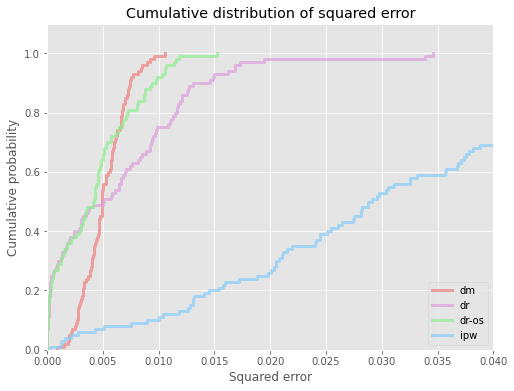

In [ ]:
# visualize cdf of squared errors for all ope estimators
evaluator.visualize_cdf_aggregate(xmax=0.04)

In [ ]:
# compute the au-cdf score (area under cdf of squared error over interval [0, thershold]), higher score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
au_cdf = evaluator.calculate_au_cdf_score(threshold=0.004)
au_cdf

{'dm': 0.00033589502028330694,
 'dr': 0.0014055338062930914,
 'dr-os': 0.0013860259381295891,
 'ipw': 0.00014759092699132635}

In [ ]:
# by activating the `scale` option, 
# we obtain au_cdf scores where the highest score is scaled to 1
au_cdf_scaled = evaluator.calculate_au_cdf_score(threshold=0.004, scale=True)
au_cdf_scaled

{'dm': 0.23898039220357525,
 'dr': 1.0,
 'dr-os': 0.9861206695447962,
 'ipw': 0.10500702745854104}

In [ ]:
# compute the cvar score (expected value of squared error above probability alpha), lower score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
cvar = evaluator.calculate_cvar_score(alpha=90)
cvar

{'dm': 0.008580224748971405,
 'dr': 0.019949401328702467,
 'dr-os': 0.011156923196551578,
 'ipw': 0.18231332465193878}

In [ ]:
# by activating the `scale` option, 
# we obtain cvar scores where the lowest score is scaled to 1
cvar_scaled = evaluator.calculate_cvar_score(alpha=90, scale=True)
cvar_scaled

{'dm': 1.0,
 'dr': 2.3250441465526874,
 'dr-os': 1.3003066379920953,
 'ipw': 21.24808265352192}